In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

In [3]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# ディレクトリが存在しない場合は作成
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # データの書式設定
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # CSV ファイルに書き込む
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [4]:
# 'spam' のラベルを 1、'ham' のラベルを 0 に変更
target = [1 if x=='spam' else 0 for x in target]

In [5]:
# 小文字に変換
texts = [x.lower() for x in texts]

# 句読点を削除
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# 数字を削除
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# 余分なホワイトスペースを削除
texts = [' '.join(x.split()) for x in texts]

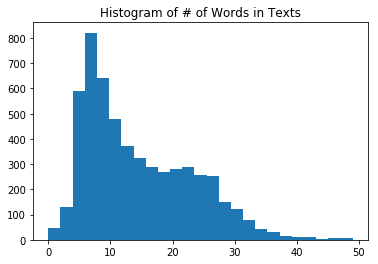

In [6]:
# テキストの長さをヒストグラムとしてプロット
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [7]:
sentence_size = 25
min_word_freq = 3

In [9]:
# 語彙プロセッサを設定
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# 一意な単語の長さを取得するために適合と変換を実行
vocab_processor.transform(texts)
embedding_size = len([x for x in vocab_processor.transform(texts)])

In [10]:
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [11]:
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

In [12]:
# ロジスティック回帰の変数を作成
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# プレースホルダを初期化
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

In [13]:
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

In [14]:
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [17]:
# 損失関数を設定
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
# 予測演算を設定
prediction = tf.sigmoid(model_output)

# 最適化関数を設定
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [18]:
init = tf.global_variables_initializer()
sess.run(init)

In [19]:
# ロジスティック回帰の開始
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # 最後の50 回の観測について正解率の移動平均を追跡
    # 1つの観測の予測値を取得
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # 予測が正解かどうかを真偽値で取得
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 1.3829
Training Observation #20: Loss = 0.168163
Training Observation #30: Loss = 0.624816
Training Observation #40: Loss = 0.829035
Training Observation #50: Loss = 1.13093
Training Observation #60: Loss = 0.781089
Training Observation #70: Loss = 9.40186
Training Observation #80: Loss = 8.46548e-06
Training Observation #90: Loss = 1.34957e-06
Training Observation #100: Loss = 0.120943
Training Observation #110: Loss = 0.00017632
Training Observation #120: Loss = 0.255709
Training Observation #130: Loss = 0.193408
Training Observation #140: Loss = 0.000905866
Training Observation #150: Loss = 1.5051
Training Observation #160: Loss = 0.00519117
Training Observation #170: Loss = 0.0113198
Training Observation #180: Loss = 0.000295906
Training Observation #190: Loss = 0.000339607
Training Observation #200: Loss = 0.0185215
Training Observation #210: Loss = 0.0108108
Training Observation #220: Loss = 0.000468825
Train

Training Observation #1840: Loss = 9.3379e-07
Training Observation #1850: Loss = 0.00782798
Training Observation #1860: Loss = 0.000874001
Training Observation #1870: Loss = 0.00800552
Training Observation #1880: Loss = 0.00098489
Training Observation #1890: Loss = 0.00131933
Training Observation #1900: Loss = 0.00286281
Training Observation #1910: Loss = 0.000599605
Training Observation #1920: Loss = 0.0451879
Training Observation #1930: Loss = 0.0035562
Training Observation #1940: Loss = 0.181744
Training Observation #1950: Loss = 0.000183034
Training Observation #1960: Loss = 0.00378082
Training Observation #1970: Loss = 0.000252055
Training Observation #1980: Loss = 4.12983e-05
Training Observation #1990: Loss = 0.723565
Training Observation #2000: Loss = 2.5297
Training Observation #2010: Loss = 0.000256115
Training Observation #2020: Loss = 0.0744991
Training Observation #2030: Loss = 0.00204064
Training Observation #2040: Loss = 0.00355064
Training Observation #2050: Loss = 0.07

Training Observation #3650: Loss = 3.87848
Training Observation #3660: Loss = 0.0135814
Training Observation #3670: Loss = 1.16938
Training Observation #3680: Loss = 0.00162746
Training Observation #3690: Loss = 0.00217232
Training Observation #3700: Loss = 0.000690775
Training Observation #3710: Loss = 0.000483281
Training Observation #3720: Loss = 0.000240928
Training Observation #3730: Loss = 4.54328e-05
Training Observation #3740: Loss = 0.0792721
Training Observation #3750: Loss = 0.00726519
Training Observation #3760: Loss = 0.00477697
Training Observation #3770: Loss = 1.17415
Training Observation #3780: Loss = 0.000130687
Training Observation #3790: Loss = 0.000415196
Training Observation #3800: Loss = 2.36095
Training Observation #3810: Loss = 0.00396371
Training Observation #3820: Loss = 0.000152011
Training Observation #3830: Loss = 0.0407253
Training Observation #3840: Loss = 0.0300739
Training Observation #3850: Loss = 0.0156163
Training Observation #3860: Loss = 6.8248
Tr